In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import pickle as pkl
import sktime.classification.interval_based as tsc_int
import sktime.classification.kernel_based as tsc_ker
import sktime.classification.compose as tsc_com
import sktime.datatypes._panel._convert as convert 
import stickleback.stickleback as sb
import stickleback.util as sb_util
import stickleback.visualize as sb_viz
import sys

from pdb import set_trace

In [3]:
## Parameters
datapath = 'bw_lunges_sensors_events.pkl'
win_size = 60
n_fit = 6
n_est = 12
n_cores = 8

In [4]:
## Load data
sensors, events = pd.read_pickle(datapath)

## TEST ONLY
## Subset deployments and keep only the first few hours of training deployments
keep = list(sensors.keys()) #[0:12]
sensors2 = dict()
events2 = dict()
max_hours = 4
for i, k in enumerate(keep):
    if i < n_fit:
        sensors2[k] = sensors[k].iloc[0:(max_hours * 3600 * 10)]
        events2[k] = events[k][events[k] < sensors2[k].index[-1]]
    else:
        sensors2[k] = sensors[k]
        events2[k] = events[k]
        
    if len(events2[k]) == 0:
        raise RuntimeError("no events in first {} hours of {}".format(max_hours, k))
        
sensors = sensors2
events = events2

# Remove events near boundaries
for deployid in events:
    t1 = sensors[deployid].index[int(win_size / 2)]
    t2 = sensors[deployid].index[int(-win_size / 2)]
    events[deployid] = events[deployid][events[deployid].to_series().between(t1, t2)]
events = sb_util.align_events(events, sensors)
for d in sensors:
    sensors[d] = sensors[d].interpolate().fillna(method="backfill")

In [5]:
## Initialize Stickleback
stsf = tsc_com.ColumnEnsembleClassifier(
    estimators = [('STSF_{}'.format(col),
                   tsc_int.SupervisedTimeSeriesForest(n_estimators=n_est, n_jobs=n_cores),
                   [i])
                  for i, col in enumerate(sensors[list(sensors.keys())[0]].columns)]
)

breath_sb = sb.Stickleback(
    local_clf=stsf,
    win_size=win_size,
    tol=pd.Timedelta("3s"),
    nth=5,
    n_folds=4
)

In [6]:
## Split test, train
def split_dict(dict, keys):
    dict1 = {k: v for k, v in dict.items() if k in keys}
    dict2 = {k: v for k, v in dict.items() if k not in keys}
    return dict1, dict2

deployids = np.array(list(sensors.keys()))
train_ids = deployids[0:n_fit]
sensors_train, sensors_test = split_dict(sensors, train_ids)
events_train, events_test = split_dict(events, train_ids)
print("training on {}".format(list(sensors_train.keys())))
print("testing on {}".format(list(sensors_test.keys())))

training on ['bw180905-53', 'bw180905-49', 'bw180905-42', 'bw180904-52', 'bw180904-48', 'bw180904-44']
testing on ['bw180830-52b', 'bw180830-52a', 'bw180830-49', 'bw180830-48', 'bw180830-46', 'bw180830-42', 'bw180830-40', 'bw180829-47', 'bw180829-30', 'bw180828-49', 'bw180828-48b', 'bw180827-53', 'bw180827-52', 'bw180827-46', 'bw170816-27', 'bw170815-28', 'bw170815-21', 'bw170814-51', 'bw170814-50', 'bw170814-40', 'bw170814-31', 'bw170813-44']


In [7]:
## Fit to training data
fit_start = datetime.now()
print("fitting (start at {})...".format(fit_start.strftime("%Y-%m-%d %H:%M:%S")))
breath_sb.fit(sensors_train, events_train) #, mask=depth_mask)
fit_finish = datetime.now()
print("fitting done at {}".format(fit_finish.strftime("%Y-%m-%d %H:%M:%S")))

fitting (start at 2021-09-29 16:58:21)...
fitting done at 2021-09-29 17:01:35


In [8]:
## Predict on test data and assess
pred_start = datetime.now()
print("predicting (start at {})...".format(pred_start.strftime("%Y-%m-%d %H:%M:%S")))
event_pred = breath_sb.predict(sensors_test)
pred_finish = datetime.now()
print("predicting done at {}".format(pred_finish.strftime("%Y-%m-%d %H:%M:%S")))
event_outcomes = breath_sb.assess(event_pred, events_test)

predicting (start at 2021-09-29 17:01:35)...
predicting done at 2021-09-29 17:29:31


In [9]:
## Save output
outdir = os.path.join(os.path.dirname(datapath), datetime.now().strftime("run-stickleback-lunges-%Y%m%d%H%M%S"))
os.mkdir(outdir)
outfile = os.path.join(outdir, "results.pkl")
sb_util.save_fitted(breath_sb, outfile, sensors, events, None, event_pred)
print("Results saved to {}".format(outfile))

## Print result
out_tbl = sb_viz.outcome_table(event_outcomes, sensors_test)
out_tbl

Results saved to run-stickleback-lunges-20210929172933\results.pkl


,F1,TP,FP,FN,True rate (events/hr),Pred. rate (events/hr),Duration (hours)
deployid,,,,,,,
bw170813-44,0.399690,515,1492,55,15.221299,53.594993,37.447528
bw170814-31,0.982880,488,17,0,59.547900,61.622314,8.195083
bw170814-40,0.646660,905,970,19,30.200986,61.284468,30.595028
bw170814-50,0.971259,490,20,9,64.490883,65.912526,7.737528
bw170814-51,0.979381,1140,38,10,53.512916,54.815839,21.490139
bw170815-21,0.862876,129,35,6,45.350628,55.092614,2.976806
bw170815-28,0.969596,1451,80,11,51.988589,54.442223,28.121556
bw170816-27,0.978304,248,11,0,55.707039,58.177916,4.451861
bw180827-46,0.973005,1622,38,52,38.585525,38.262827,43.384144


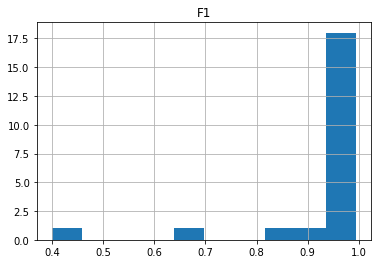

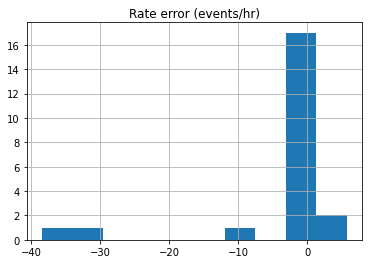

In [10]:
# Plot F1 and rate error distributions
f1_hist = out_tbl.hist("F1")
out_tbl["Rate error (events/hr)"] = out_tbl["True rate (events/hr)"] - out_tbl["Pred. rate (events/hr)"]
rateerr_hist = out_tbl.hist("Rate error (events/hr)")

In [ ]:
# Plot predictions (interactive)
deployid = 'bw170813-44'
sb_viz.plot_predictions(deployid, sensors, event_pred, event_outcomes)